In [1]:
import os 
import pickle
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tqdm import tqdm

2025-05-01 19:43:29.690086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746128609.922269      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746128609.981082      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:

base_model = VGG16(weights=None)


weights_path = '/kaggle/input/backup/keras/default/1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
base_model.load_weights(weights_path)


model_vgg = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

I0000 00:00:1746128622.428633      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/input/backup/keras/default/1/vgg16_weights_tf_dim_ordering_tf_kernels.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:

def load_flickr8k_captions(file_path):
    mapping = {}
    with open(file_path, 'r') as f:
        for line in f:
            tokens = line.strip().split()
            if len(tokens) < 2:
                continue
            image_name, caption = tokens[0], ' '.join(tokens[1:])
            image_id = image_name.split('.')[0]  
            if image_id not in mapping:
                mapping[image_id] = []
            mapping[image_id].append(caption)
    return mapping

flickr8k_captions_file = '/kaggle/input/flickr8k/captions.txt'
flickr8k_mapping = load_flickr8k_captions(flickr8k_captions_file)


import os
flickr8k_image_dir = '/kaggle/input/flickr8k/Images'
flickr8k_image_files = [f for f in os.listdir(flickr8k_image_dir) if f.endswith('.jpg')]
flickr8k_image_id_to_filename = {f.split('.')[0]: f for f in flickr8k_image_files}


print("مثال لـ Flickr8k mapping:")
for image_id, caps in list(flickr8k_mapping.items())[:2]:
    print(f"Image ID: {image_id}, Captions: {caps}")

In [ ]:
import json
import os


json_path = '/kaggle/input/mini-coco2014-dataset-for-image-captioning/captions.json'
with open(json_path, 'r') as f:
    coco_data = json.load(f)

captions = coco_data  


coco_mapping = {}
for annotation in captions:
    image_id = str(annotation['image_id'])
    caption = annotation['caption']
    if image_id not in coco_mapping:
        coco_mapping[image_id] = []
    coco_mapping[image_id].append(caption)


coco_image_dir = '/kaggle/input/mini-coco2014-dataset-for-image-captioning/Images'
coco_image_files = [f for f in os.listdir(coco_image_dir) if f.endswith('.jpg')]
coco_image_id_to_filename = {}
for filename in coco_image_files:
    image_id = filename.split('_')[-1].split('.')[0]
    image_id = str(int(image_id))
    coco_image_id_to_filename[image_id] = filename


print("مثال لـ COCO mapping:")
for image_id, caps in list(coco_mapping.items())[:2]:
    print(f"Image ID: {image_id}, Captions: {caps}")

In [ ]:

combined_mapping = {}

flickr_captions_file = "/kaggle/input/flickr8k/captions.txt"  
with open(flickr_captions_file, 'r') as f:
    flickr_captions = f.readlines()

for line in flickr_captions[1:]: 
    parts = line.strip().split(',')
    image_name = parts[0]  
    caption = parts[1]
    image_id = "flickr_" + image_name.split('.')[0]  
    if image_id not in combined_mapping:
        combined_mapping[image_id] = []
    combined_mapping[image_id].append(caption)


import json

coco_captions_file = "/kaggle/input/mini-coco2014-dataset-for-image-captioning/captions.json"  
with open(coco_captions_file, 'r') as f:
    coco_data = json.load(f)


for annotation in coco_data:
    image_id_num = annotation['image_id']  
    caption = annotation['caption']

    image_id = f"coco_{image_id_num}"  # مثلاً coco_247
    if image_id not in combined_mapping:
        combined_mapping[image_id] = []
    combined_mapping[image_id].append(caption)


print(f"عدد الصور في combined_mapping: {len(combined_mapping)}")

with open('combined_mapping.pkl', 'wb') as handle:
    pickle.dump(combined_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("تم حفظ combined_mapping في ملف combined_mapping.pkl")

عدد الصور في combined_mapping: 26874
تم حفظ combined_mapping في ملف combined_mapping.pkl


In [ ]:
import os


combined_image_id_to_filename = {}


flickr_image_dir = "/kaggle/input/flickr8k/Images"  
flickr_images = os.listdir(flickr_image_dir)
for image_name in flickr_images:
    if image_name.endswith('.jpg'):
        image_id = "flickr_" + image_name.split('.')[0]  
        combined_image_id_to_filename[image_id] = (flickr_image_dir, image_name)


coco_image_dir = "/kaggle/input/mini-coco2014-dataset-for-image-captioning/Images"  
coco_images = os.listdir(coco_image_dir)
for image_name in coco_images:
    if image_name.endswith('.jpg'):
        image_id_num = image_name.split('_')[-1].split('.')[0]  
        image_id = f"coco_{int(image_id_num)}"  
        combined_image_id_to_filename[image_id] = (coco_image_dir, image_name)


print(f"عدد الصور في combined_image_id_to_filename: {len(combined_image_id_to_filename)}")

filename_to_image_id = {}
for image_id, (image_dir, image_name) in combined_image_id_to_filename.items():
    filename_to_image_id[image_name] = image_id

print(f"عدد الصور في filename_to_image_id: {len(filename_to_image_id)}")

عدد الصور في combined_image_id_to_filename: 26874
عدد الصور في filename_to_image_id: 26874


In [ ]:

filename_to_image_id = {}
for image_id, (image_dir, image_name) in combined_image_id_to_filename.items():
    filename_to_image_id[image_name] = image_id

print(f"عدد الصور في filename_to_image_id: {len(filename_to_image_id)}")

عدد الصور في filename_to_image_id: 26874


In [ ]:

def extract_features(combined_image_id_to_filename):
    features = {}
    for image_id, (image_dir, filename) in tqdm(combined_image_id_to_filename.items()):
        img_path = os.path.join(image_dir, filename)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model_vgg.predict(image, verbose=0)
        features[image_id] = feature
    return features


features = extract_features(combined_image_id_to_filename)


import pickle
with open('combined_features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer


all_captions = []
for caps in combined_mapping.values():
    all_captions.extend(caps)


all_captions = [f"startseq {caption} endseq" for caption in all_captions]


tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)


with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


vocab_size = len(tokenizer.word_index) + 1
print(f"Vocab Size: {vocab_size}")


maxLength = max(len(caption.split()) for caption in all_captions)
print(f"Max Length: {maxLength}")

Vocab Size: 15404
Max Length: 51


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import random
from sklearn.model_selection import train_test_split

In [ ]:

all_keys = list(combined_mapping.keys())
random.shuffle(all_keys)
train_size = int(0.8 * len(all_keys)) 
train_keys = all_keys[:train_size]
val_keys = all_keys[train_size:]

train_mapping = {key: combined_mapping[key] for key in train_keys}
val_mapping = {key: combined_mapping[key] for key in val_keys}

In [11]:
def data_generator(mapping, features, tokenizer, maxLength, batch_size, shuffle=True):
    X1, X2, y = [], [], []
    n = 0
    items = list(mapping.items())
    if shuffle:
        random.shuffle(items)
    
    while True:
        for image_id, captions in items:
            captions = captions.copy()
            if shuffle:
                random.shuffle(captions)
            for caption in captions:
                caption = f"startseq {caption} endseq"
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=maxLength, padding='post', truncating='post')[0]
                    out_seq = np.zeros(vocab_size)
                    out_seq[seq[i]] = 1
                    
                    X1.append(features[image_id][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
                    n += 1
                    if n == batch_size:
                        yield (tf.convert_to_tensor(X1), tf.convert_to_tensor(X2)), tf.convert_to_tensor(y)
                        X1, X2, y = list(), list(), list()
                        n = 0
        if shuffle:
            random.shuffle(items)

In [ ]:
import gc
# مسح الذاكرة قبل التدريب
gc.collect()
tf.keras.backend.clear_session()

tokenizer_path = '/kaggle/input/backup/keras/default/6/tokenizer.pkl'  
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

# تحميل الـ features
features_path = '/kaggle/input/backup/keras/default/6/combined_features.pkl'  
with open(features_path, 'rb') as handle:
    features = pickle.load(handle)
vocab_size = len(tokenizer.word_index) + 1
maxLength = 51
keys = list(combined_mapping.keys())
train_keys, val_keys = train_test_split(keys, test_size=0.1, random_state=42)
train_mapping = {k: combined_mapping[k] for k in train_keys}
val_mapping = {k: combined_mapping[k] for k in val_keys}


In [ ]:

input1 = Input(shape=(4096,))  
fe1 = Dropout(0.4)(input1)  
fe2 = Dense(256, activation='relu')(fe1)  

input2 = Input(shape=(maxLength,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(input2)  
se2 = Dropout(0.4)(se1)  
se3 = LSTM(256)(se2)  
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)  
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=outputs)


optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


early_stopping = EarlyStopping(
    monitor='loss',  
    patience=3,      
    restore_best_weights=True  
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_checkpoint.keras', monitor='val_loss', save_best_only=True, verbose=1)


batch_size = 64
train_steps = sum(len(caps) for caps in train_mapping.values()) // batch_size
val_steps = sum(len(caps) for caps in val_mapping.values()) // batch_size
epochs = 30
train_generator = data_generator(train_mapping, features, tokenizer, maxLength, batch_size, shuffle=True)
val_generator = data_generator(val_mapping, features, tokenizer, maxLength, batch_size, shuffle=False)


history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    verbose=1,
    callbacks=[early_stopping, checkpoint]
)



In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:

model.save('combined_captioning_model.keras')

In [ ]:
from tensorflow.keras.models import Model, load_model
model_path = '/kaggle/input/backup/keras/default/6/combined_captioning_model (52).keras'
model = load_model(model_path)
tokenizer_path = '/kaggle/input/backup/keras/default/6/tokenizer.pkl'  
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [13]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

In [15]:
def predictCaption(model, image_feature, tokenizer, maxLength):
    in_text = 'startseq'
    for _ in range(maxLength):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=maxLength, padding='post', truncating='post')
        yhat = model.predict([image_feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxToWord(yhat, tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text.replace('startseq ', '').replace(' endseq', '')

In [16]:
def idxToWord(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [17]:
test = list(combined_mapping.keys())[:1000]
test = [key for key in test if key in features]

In [44]:
actual, predicted = list(), list()
for key in tqdm(test):
    captions = combined_mapping[key]
    y_pred = predictCaption(model, features[key], tokenizer, maxLength)
    actualCaption = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actualCaption)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 1000/1000 [12:02<00:00,  1.38it/s]


BLEU-1: 0.506413
BLEU-2: 0.322299


---------------------Actual Caption---------------------
A man with the Monster logo shirt is surfing .
A surfer is riding numerous waves .
A surfer on a roiling wave .
A surfer rides on a very rough wave .
Person surfing on a white surfboard .


I0000 00:00:1746128787.976721      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


---------------------Predicted Caption---------------------
a man in a red suit is riding a wave


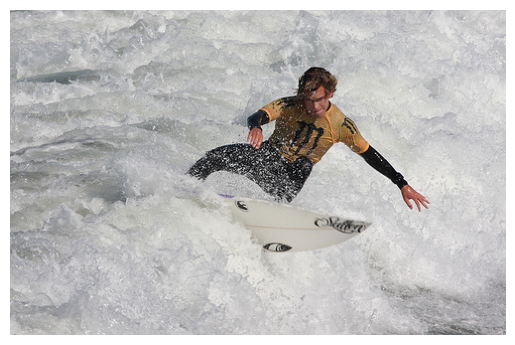

---------------------Actual Caption---------------------
the people are sampling wine at a wine tasting.
Group of people tasting wine next to some barrels.
People are gathered around a man tasting wine.
A man pouring wine from casks for patrons
People gather around a table while sampling wine.
---------------------Predicted Caption---------------------
a man in a white shirt is sitting at a table


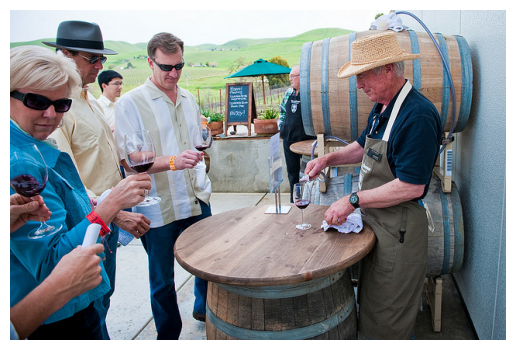

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generateCaption(image_filename):

    try:
        image_id = filename_to_image_id[image_filename]
    except KeyError:
        print(f"خطأ: اسم الصورة {image_filename} مش موجود في القاموس filename_to_image_id!")
        return
    

    try:
        image_dir, image_name = combined_image_id_to_filename[image_id]
        img_path = os.path.join(image_dir, image_name)
        image = Image.open(img_path)
    except KeyError:
        print(f"خطأ: الصورة {image_id} مش موجودة في القاموس combined_image_id_to_filename!")
        return
    except FileNotFoundError:
        print(f"خطأ: ملف الصورة {img_path} مش موجود!")
        return
    

    try:
        captions = combined_mapping[image_id]
    except KeyError:
        print(f"خطأ: الصورة {image_id} مش موجودة في combined_mapping!")
        return
    
    print('---------------------Actual Caption---------------------')
    for caption in captions:
        print(caption)
    

    try:
        if 'model' not in globals() or model is None:
            raise ValueError("النموذج (model) غير معرّف أو قيمته None!")
        if 'tokenizer' not in globals() or tokenizer is None:
            raise ValueError("الـ tokenizer غير معرّف أو قيمته None!")
        if 'maxLength' not in globals() or maxLength <= 0:
            raise ValueError(f"maxLength غير معرّف أو قيمته غير صالحة: {maxLength}")
        if image_id not in features:
            raise KeyError(f"الصورة {image_id} مش موجودة في features!")
        
   
        y_pred = predictCaption(model, features[image_id], tokenizer, maxLength)
        print('---------------------Predicted Caption---------------------')
        print(y_pred)
    except Exception as e:
        print(f"خطأ أثناء توليد التعليق: {str(e)}")
        return
    

    plt.imshow(image)
    plt.axis('off')
    plt.show()

generateCaption('3331900249_5872e90b25.jpg')

generateCaption('COCO_train2014_000000000308.jpg')